# Powering applications with Large Language Models

In [18]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_TYPE"] 
os.environ["OPENAI_API_VERSION"] 
os.environ["OPENAI_API_BASE"] 
os.environ["OPENAI_API_KEY"] 
os.environ["AZURE_COGS_KEY"] 
os.environ["AZURE_COGS_ENDPOINT"] 
os.environ["AZURE_COGS_REGION"] 

'eastus'

In [36]:
from langchain.chat_models import AzureChatOpenAI

llm = AzureChatOpenAI(
    deployment_name='gpt-4',
    openai_api_type="azure",
    temperature = 0
)

## Simple agent with internet access

In [37]:
from langchain import SerpAPIWrapper
from langchain.agents import AgentType, initialize_agent
from langchain.llms import OpenAI
from langchain.tools import BaseTool, StructuredTool, Tool, tool

import os
from dotenv import load_dotenv

load_dotenv()

key = os.environ["SERPAPI_API_KEY"]

search = SerpAPIWrapper()

In [54]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
            memory_key='chat_history',
            return_messages=True
        )

In [55]:
from langchain.agents.agent_toolkits import create_conversational_retrieval_agent

tools = [
    Tool.from_function(
        func=search.run,
        name="Search",
        description="useful for when you need to answer questions about current events"),
    ]



In [56]:
from langchain.agents import initialize_agent

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
agent_chain = initialize_agent(tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, memory=memory, handle_parsing_errors=True)

In [49]:
print(agent_chain.agent.llm_chain.prompt.template)

Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks 

In [57]:
agent_chain({"input": "what is the plot of avatar 2?"})



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Search
Action Input: Avatar 2 plot
Observation: Jake Sully and Ney'tiri have formed a family and are doing everything to stay together. However, they must leave their home and explore the regions of Pandora. When an ancient threat resurfaces, Jake must fight a difficult war against the humans.
Thought:Do I need to use a tool? No
AI: The plot of Avatar 2 revolves around Jake Sully and Ney'tiri, who have now formed a family and are striving to stay together. However, circumstances force them to leave their home and explore different regions of Pandora. Their journey becomes more challenging when an ancient threat resurfaces, and Jake finds himself in a difficult war against the humans.

> Finished chain.


{'input': 'what is the plot of avatar 2?',
 'chat_history': [HumanMessage(content='what is the plot of avatar 2?'),
  AIMessage(content="The plot of Avatar 2 revolves around Jake Sully and Ney'tiri, who have now formed a family and are striving to stay together. However, circumstances force them to leave their home and explore different regions of Pandora. Their journey becomes more challenging when an ancient threat resurfaces, and Jake finds himself in a difficult war against the humans.")],
 'output': "The plot of Avatar 2 revolves around Jake Sully and Ney'tiri, who have now formed a family and are striving to stay together. However, circumstances force them to leave their home and explore different regions of Pandora. Their journey becomes more challenging when an ancient threat resurfaces, and Jake finds himself in a difficult war against the humans."}

## DBCopilot

In [41]:
import sqlite3
import pandas as pd
## creating a connection
database = 'chinook.db'


conn = sqlite3.connect(database)

## importing tables 
tables = pd.read_sql("""SELECT name, type
                        FROM sqlite_master
                        WHERE type IN ("table", "view");""", conn)

tables

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [42]:
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain.llms.openai import OpenAI
from langchain.agents import AgentExecutor
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI

db = SQLDatabase.from_uri('sqlite:///chinook.db')

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

agent_executor.run("Describe the playlisttrack table")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""
Observation: album, artist, customer, employee, genre, invoice, invoice_line, media_type, playlist, playlist_track, track
Thought:The playlisttrack table is in the database. I should query its schema to describe it.
Action: sql_db_schema
Action Input: "playlist_track"
Observation: 
CREATE TABLE playlist_track (
	playlist_id INTEGER NOT NULL, 
	track_id INTEGER NOT NULL, 
	PRIMARY KEY (playlist_id, track_id), 
	FOREIGN KEY(track_id) REFERENCES track (track_id), 
	FOREIGN KEY(playlist_id) REFERENCES playlist (playlist_id)
)

/*
3 rows from playlist_track table:
playlist_id	track_id
1	3402
1	3389
1	3390
*/
Thought:I now know that the playlisttrack table has two columns, playlist_id and track_id, and is a junction table between the playlist and track tables. I don't need to run a query for this question.
Final Answer: The playlisttrack table has two columns, playlist_id and track_id, and is a junction table

'The playlisttrack table has two columns, playlist_id and track_id, and is a junction table between the playlist and track tables.'

In [43]:
agent_executor.run("What are the top 5 countries for sales?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ''
Observation: album, artist, customer, employee, genre, invoice, invoice_line, media_type, playlist, playlist_track, track
Thought:I should query the invoice and customer tables to get the sales by country.
Action: sql_db_schema
Action Input: 'invoice, customer'
Observation: Error: table_names {"customer'", "'invoice"} not found in database
Thought:I made a typo in the input for sql_db_schema. I need to remove the quotes around the table names.
Action: sql_db_schema
Action Input: invoice, customer
Observation: 
CREATE TABLE customer (
	customer_id INTEGER NOT NULL, 
	first_name NVARCHAR(40) NOT NULL, 
	last_name NVARCHAR(20) NOT NULL, 
	company NVARCHAR(80), 
	address NVARCHAR(70), 
	city NVARCHAR(40), 
	state NVARCHAR(40), 
	country NVARCHAR(40), 
	postal_code NVARCHAR(10), 
	phone NVARCHAR(24), 
	fax NVARCHAR(24), 
	email NVARCHAR(60) NOT NULL, 
	support_rep_id INTEGER, 
	PRIMARY KEY (customer_id), 
	F

c:\Users\vaalt\AppData\Local\anaconda3\lib\site-packages\langchain\utilities\sql_database.py:351: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  sample_rows_result = connection.execute(command)  # type: ignore


I can join the invoice and customer tables on the customer_id column, group by country, and order by total sales to get the top 5 countries for sales.
Action: sql_db_query_checker
Action Input: 
SELECT customer.country, SUM(invoice.total) AS total_sales
FROM invoice
JOIN customer ON invoice.customer_id = customer.customer_id
GROUP BY customer.country
ORDER BY total_sales DESC
LIMIT 5;
Observation: SELECT customer.country, SUM(invoice.total) AS total_sales
FROM invoice
JOIN customer ON invoice.customer_id = customer.customer_id
GROUP BY customer.country
ORDER BY total_sales DESC
LIMIT 5;
Thought:The query looks correct, so I should execute it to get the answer.
Action: sql_db_query
Action Input: 
SELECT customer.country, SUM(invoice.total) AS total_sales
FROM invoice
JOIN customer ON invoice.customer_id = customer.customer_id
GROUP BY customer.country
ORDER BY total_sales DESC
LIMIT 5;
Observation: [('USA', 1040.4899999999998), ('Canada', 535.5900000000001), ('Brazil', 427.6800000000000

'USA, Canada, Brazil, France, and Germany.'

In [45]:
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)
agent_executor.run('what is the total number of tracks and the average length of tracks by genre?')



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""
Observation: album, artist, customer, employee, genre, invoice, invoice_line, media_type, playlist, playlist_track, track
Thought:I should query the schema of the genre and track tables to see what columns I can use to answer the question.
Action: sql_db_schema
Action Input: "genre, track"
Observation: 
CREATE TABLE genre (
	genre_id INTEGER NOT NULL, 
	name NVARCHAR(120), 
	PRIMARY KEY (genre_id)
)

/*
3 rows from genre table:
genre_id	name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE track (
	track_id INTEGER NOT NULL, 
	name NVARCHAR(200) NOT NULL, 
	album_id INTEGER, 
	media_type_id INTEGER NOT NULL, 
	genre_id INTEGER, 
	composer NVARCHAR(220), 
	milliseconds INTEGER NOT NULL, 
	bytes INTEGER, 
	unit_price NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY (track_id), 
	FOREIGN KEY(media_type_id) REFERENCES media_type (media_type_id), 
	FOREIGN KEY(genre_id) REFERENCES genre (genre_id), 
	FOREIGN KEY(album_id) REFE

'The total number of tracks and the average length of tracks by genre are: \nRock - 1297 tracks, 262840.853840304 milliseconds average track length\nLatin - 579 tracks, 259977.585034013 milliseconds average track length\nMetal - 374 tracks, 287996.836898395 milliseconds average track length\nAlternative & Punk - 332 tracks, 233738.594578313 milliseconds average track length\nJazz - 130 tracks, 356399.161538462 milliseconds average track length\nTV Shows - 93 tracks, 1429867.74193548 milliseconds average track length\nBlues - 81 tracks, 261516.049382716 milliseconds average track length\nClassical - 74 tracks, 262850.675675676 milliseconds average track length\nDrama - 64 tracks, 2576752.5 milliseconds average track length\nR&B/Soul - 61 tracks, 251096.721311475 milliseconds average track length'

## Multi-modal agents

### Story teller from images

In [46]:
from langchain.agents.agent_toolkits import AzureCognitiveServicesToolkit

toolkit = AzureCognitiveServicesToolkit()

[tool.name for tool in toolkit.get_tools()]

['azure_cognitive_services_form_recognizer',
 'azure_cognitive_services_speech2text',
 'azure_cognitive_services_text2speech',
 'azure_cognitive_services_image_analysis']

In [47]:
from langchain.agents import initialize_agent, AgentType

agent = initialize_agent(
    tools=toolkit.get_tools(),
    llm=llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)

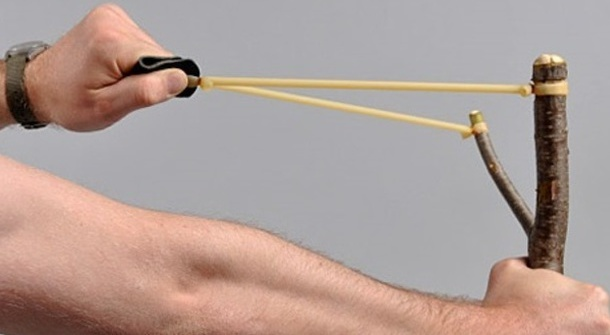

In [48]:
from IPython.display import Image, display
display(Image('https://www.stylo24.it/wp-content/uploads/2020/03/fionda.jpg', width=600, unconfined=True))

In [49]:
agent.run("what happens if the person lets the slingshot go?:'https://www.stylo24.it/wp-content/uploads/2020/03/fionda.jpg'")



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://www.stylo24.it/wp-content/uploads/2020/03/fionda.jpg"
  }
}
```

Observation: Caption: a person holding a slingshot
Tags: person, tool, nail, hand, holding, needle
Thought:Based on the image analysis, it appears that the person in the image is holding a slingshot. 

To answer the question, if the person were to let go of the slingshot, the projectile (such as a rock or ball) would be launched forward due to the tension in the rubber bands. The speed and distance of the projectile would depend on various factors such as the strength of the rubber bands, the weight of the projectile, and the angle at which the slingshot is held. 

Action:
```
{
  "action": "Final Answer",
  "action_input": "If the person were to let go of the slingshot, the projectile would be launched forward due to the tension in the rubber bands. The speed and distance 

'If the person were to let go of the slingshot, the projectile would be launched forward due to the tension in the rubber bands. The speed and distance of the projectile would depend on various factors such as the strength of the rubber bands, the weight of the projectile, and the angle at which the slingshot is held.'

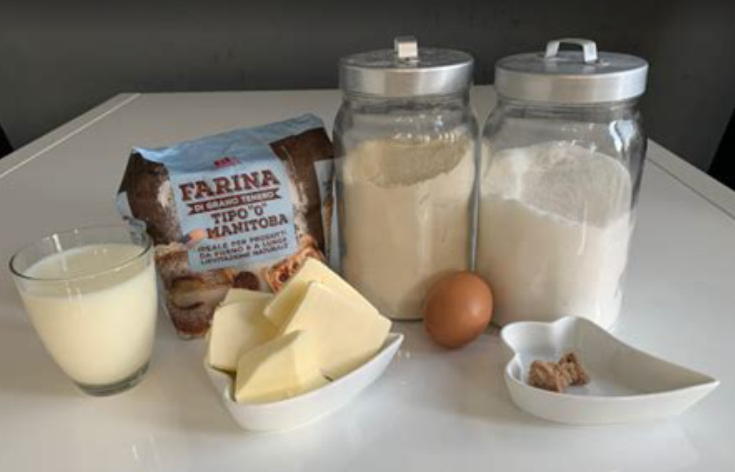

In [59]:
from IPython.display import Image, display
display(Image('https://i.postimg.cc/mD8wVrtb/Screenshot-2023-09-23-190012.png', width=600, unconfined=True))

In [57]:
agent.run("Tell me a typical recipe of your choice from Trentino Alto Adige I can do with the following ingredients:'https://i.postimg.cc/mD8wVrtb/Screenshot-2023-09-23-190012.png'")



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://i.postimg.cc/mD8wVrtb/Screenshot-2023-09-23-190012.png"
  }
}
```


Observation: Caption: a group of ingredients on a table
Tags: dairy, indoor, milk, food, plant milk, grain milk, almond milk, ingredient, tableware, serveware, table, cup, blender, breakfast
Text: FARINA, TIPO"O", MANITOBA
Thought:To create a typical recipe from Trentino Alto Adige with the given ingredients, I would need more information about the type of dish you would like to prepare. However, I can suggest a recipe for a traditional dish from Trentino Alto Adige called "Canederli" which is a type of dumpling made with bread and served in a broth or with a sauce. Here is the recipe:

Ingredients:
- 200g of Manitoba flour
- 200g of type "0" flour
- 3 eggs
- 100g of speck (smoked ham)
- 1 onion
- 1/2 liter of milk
- 1/2 liter of vegetable broth
- 50g of butter
- Salt an

"Here is a recipe for Canederli, a traditional dish from Trentino Alto Adige. Ingredients include Manitoba flour, type '0' flour, eggs, speck, onion, milk, vegetable broth, butter, salt, and pepper. Instructions are to sauté the speck and onion, mix the dough, form small balls, cook them in boiling salted water, and serve them in the broth or with the sauce. Enjoy!"

In [58]:
agent.run("Tell me a typical recipe of your choice from Trentino Alto Adige I can do with the following ingredients and read it aloud:'https://i.postimg.cc/mD8wVrtb/Screenshot-2023-09-23-190012.png'")



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_text2speech",
  "action_input": "To make a typical recipe from Trentino Alto Adige, you can use the following ingredients: 500g of flour, 200g of sugar, 200g of butter, 3 eggs, 1 lemon, 1 sachet of baking powder, and a pinch of salt. Would you like me to find a specific recipe for you?"
}
```


Observation: C:\Users\vaalt\AppData\Local\Temp\tmpoxjq9f1u.wav
Thought:Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://i.postimg.cc/mD8wVrtb/Screenshot-2023-09-23-190012.png"
  }
}
```

Observation: Caption: a group of ingredients on a table
Tags: dairy, indoor, milk, food, plant milk, grain milk, almond milk, ingredient, tableware, serveware, table, cup, blender, breakfast
Text: FARINA, TIPO"O", MANITOBA
Thought:Based on the ingredients in the image you provided, a typical recipe from Trentino Alto Adige that you can make is "Strudel di Mele"

'Is there anything else I can help you with?'